In [1]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import vartools as vt

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display
from sklearn.linear_model import LinearRegression

## Obtención de datos

In [2]:
tickers = ['AAPL', 'WMT', 'JPM', 'PG', 'META', 'V']
benchmark = 'SPY'

price = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Close'][tickers]
volume = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Volume'][tickers]

benchmark_data = yf.download(benchmark, start='2021-01-01', end='2025-03-12', progress=False)['Close']

rt = price.pct_change().dropna()
rt_benchmark = benchmark_data.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


In [3]:
print(f'Precios de los activos')
display(price.head())
print()

print(f'Volumen de los activos')
display(volume.head());

Precios de los activos


Ticker,AAPL,WMT,JPM,PG,META,V
Date,,,,,,
2021-01-04,126.4052,46.0713,112.3085,124.0700,267.6785,211.1414
2021-01-05,127.9680,45.8261,112.9196,124.8622,269.6989,207.9902
2021-01-06,123.6605,46.1122,118.2218,126.1766,262.0748,206.1576
2021-01-07,127.8802,46.1091,122.1042,124.9972,267.4794,207.3115
2021-01-08,128.9839,46.1028,122.2389,124.9432,266.3149,208.9016



Volumen de los activos


Ticker,AAPL,WMT,JPM,PG,META,V
Date,,,,,,
2021-01-04,143301900,32182200,16819900,8330900,15106100,10318300
2021-01-05,97664900,26498100,13731200,6856400,9871600,6869700
2021-01-06,155088000,21918900,24909100,10578000,24354100,7206200
2021-01-07,109578200,20538000,21940400,7355400,15789800,10967900
2021-01-08,105158200,24478200,12035100,7448500,18528300,6513000


In [4]:
pd.set_option('display.float_format', '{:.2%}'.format)
stats_df = pd.DataFrame({
    'Rendimiento Anual': rt.mean() * 252,
    'Volatilidad Anual': rt.std() * np.sqrt(252),
})
stats_df.T

Ticker,AAPL,WMT,JPM,PG,META,V
Rendimiento Anual,16.96%,17.44%,20.03%,9.45%,29.47%,13.41%
Volatilidad Anual,26.74%,20.19%,24.16%,17.05%,44.15%,22.53%


## Optimización y Evolución de Portafolios

### Funciones de Optimización

In [5]:
def portfolio_return(returns, weights):
    return np.dot(returns, weights)

In [6]:
def opt_sharpe(rt: pd.DataFrame, rf: float) -> np.ndarray:
    """
    Optimiza los pesos de un portafolio para maximizar el Sharpe Ratio.

    Parámetros:
    -----------
    rt : DataFrame
        Un DataFrame de pandas que contiene los rendimientos históricos diarios de los activos.
    rf : float
        Tasa libre de riesgo anualizada.

    Retorna:
    --------
    w_opt_sharpe : ndarray
        Un array con los pesos óptimos de los activos en el portafolio que maximizan el Sharpe Ratio.
    """

    # Cálculos
    mu = (rt.mean() * 252).values
    sigma = rt.cov().values
    n_assets = len(rt.keys())

    # Función para minimizar (-Sharpe Ratio)
    def neg_sharpe_ratio(w, mu, sigma, rf):
        port_return = np.dot(w.T, mu)
        port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)
        return -(port_return - rf) / port_vol
    
    # Restricciones: Suma de pesos = 1
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    # Límites: Pesos entre 0 y 1 (no posiciones cortas)
    bounds = ((0, 1),) * n_assets

    # Pesos iniciales (distribuidos uniformemente)
    w0 = np.ones(n_assets) / n_assets

    # Optimización
    result = minimize(neg_sharpe_ratio, 
            w0, 
            args=(mu, sigma, rf), 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints)
    
    weights = result.x

    return weights

In [7]:
def lvrr(price: pd.DataFrame, volume: pd.DataFrame, pv: float, rf: float) -> np.ndarray:
    """
    Optimiza la asignación de activos maximizando el Sharpe Ratio ajustado por liquidez.

    Parámetros:
    -----------
    price : DataFrame
        DataFrame con los precios históricos de los activos.
    volume : DataFrame
        DataFrame con los volúmenes históricos de los activos.
    pv : float
        Valor total del portafolio.
    rf : float
        Tasa libre de riesgo anualizada.

    Retorna:
    --------
    lvrr_weights : ndarray
        Vector con los pesos óptimos de cada activo en el portafolio.
    """

    # Cálculo de retornos esperados y matriz de covarianza
    returns = price.pct_change().dropna()

    mu = returns.mean() * 252
    sigma = returns.cov()
    n_assets = len(returns.keys())

    # Volumen promedio de los últimos 3 meses
    adv = volume.iloc[-90:, :].mean()

    def objective(w):
        # Ratio de liquidez
        H = 1 / (adv * price.iloc[-1])
        lr = np.dot(pv, np.dot(w.T, H))

        port_return = np.dot(w.T, mu)
        port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)

        return -(port_return - rf) / (port_vol * lr)
    
    # Restricciones: Suma de pesos = 1
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    # Límites: Pesos entre 0 y 1 (no posiciones cortas)
    bounds = ((0, 1),) * n_assets

    # Pesos iniciales (distribuidos uniformemente)
    w0 = np.ones(n_assets) / n_assets

    # Optimización
    result = minimize(objective, 
            w0, 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints)
    
    weights = result.x
    
    return weights

In [8]:
def semivariance(rt: pd.DataFrame, rt_benchmark:pd.DataFrame) -> np.ndarray:
    """
    Optimiza la asignación de activos minimizando la semivarianza.

    Parámetros:
    -----------
    rt : DataFrame
        DataFrame con los rendimientos históricos de los activos.
    rt_benchmark : DataFrame
        DataFrame con los rendimientos históricos del benchmark.
    Retorna:
    --------
    weights : ndarray
        Vector con los pesos óptimos de cada activo en el portafolio.
    """
    # Cálculo de la matriz de semivarianza
    diff = rt - rt_benchmark.values
    downside = diff.where(diff < 0, 0).std()
    corr = rt.corr()
    S = np.outer(downside, downside) * corr

    n_assets = len(rt.keys())

    def objective(w, S):
        return w.T @ S @ w
    
    # Restricciones: Suma de pesos = 1
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    # Límites: Pesos entre 0 y 1 (no posiciones cortas)
    bounds = ((0, 1),) * n_assets

    # Pesos iniciales (distribuidos uniformemente)
    #w0 = np.ones(n_assets) / n_assets
    #w0 = np.random.dirichlet(np.ones(len(tickers)))

    # Optimización
    """result = minimize(objective, 
            w0,
            args=(S,), 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints)"""
    
    result = shgo(objective, 
                  bounds, 
                  args=(S,),  
                  constraints=constraints)
    
    weights = result.x

    return weights

In [9]:
def omega(rt: pd.DataFrame, rt_benchmark: pd.DataFrame) -> np.ndarray:
    """
    Optimiza la asignación de activos maximizando el ratio Omega.

    Parámetros:
    -----------
    rt : DataFrame
        DataFrame con los rendimientos históricos de los activos.
    rt_benchmark : DataFrame
        DataFrame con los rendimientos históricos del benchmark.
    Retorna:
    --------
    weights : ndarray
        Vector con los pesos óptimos de cada activo en el portafolio.
    """
    
    diff = rt - rt_benchmark.values

    downside = diff.where(diff < 0, 0).std()
    upside = diff.where(diff > 0, 0).std()

    omega = upside / downside

    n_assets = len(omega)

    def objective(w, omega):
        return -np.dot(w.T, omega)
    
    # Restricciones: Suma de pesos = 1
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    # Límites: Pesos entre 0 y 1 (no posiciones cortas)
    bounds = ((0, 1),) * n_assets

    # Pesos iniciales (distribuidos uniformemente)
    w0 = np.ones(n_assets) / n_assets
    #w0 = np.random.dirichlet(np.ones(len(tickers)))

    # Optimización
    result = minimize(objective, 
            w0,
            args=(omega,), 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints)
    
    weights = result.x

    return weights

## Backtest Estático

In [10]:
pd.reset_option('display.float_format')

rf = 0.05
pv = 1000000.0

start_date = '2021-01-01'
end_date = '2023-12-31'

start_test = '2024-01-01'
end_test = '2025-03-12'
#end_test = datetime.datetime.today().strftime('%Y-%m-%d')

benchmark_test = benchmark_data.loc[start_test:end_test]

price_train = price.loc[start_date:end_date]
price_test = price.loc[start_test:end_test]

volume_train = volume.loc[start_date:end_date]
volume_test = volume.loc[start_test:end_test]

rt_train = price_train.pct_change().dropna()
rt_test = price_test.pct_change().dropna()
rt_benchmark_test = benchmark_test.pct_change().dropna()

### Máximo Ratio de Sharpe

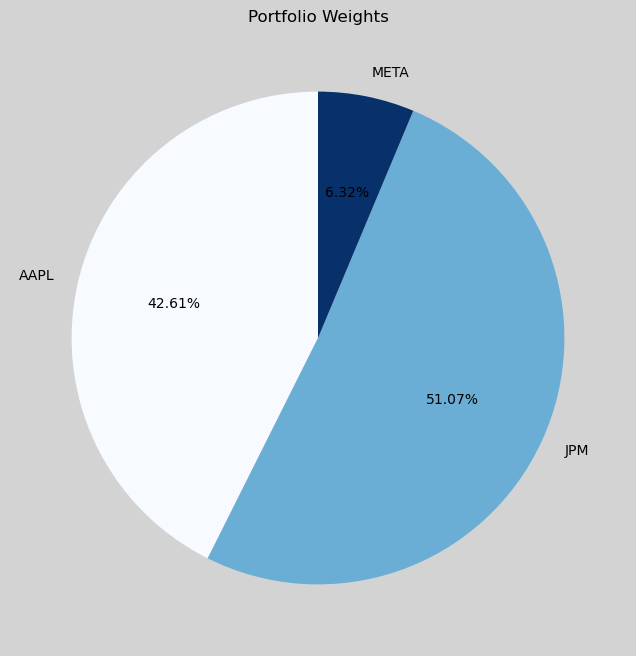

In [11]:
w_sharpe = opt_sharpe(rt_train, rf)
vt.plot_weights(tickers, w_sharpe)

### Liquidity Variance Return Ratio (LVRR)

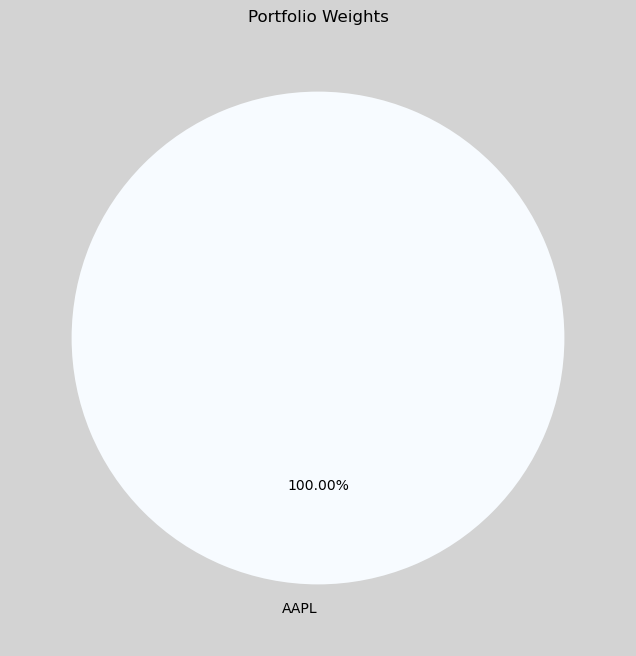

In [12]:
w_lvrr = lvrr(price_train, volume_train, pv, rf)
vt.plot_weights(tickers, w_lvrr)

### Gráfica

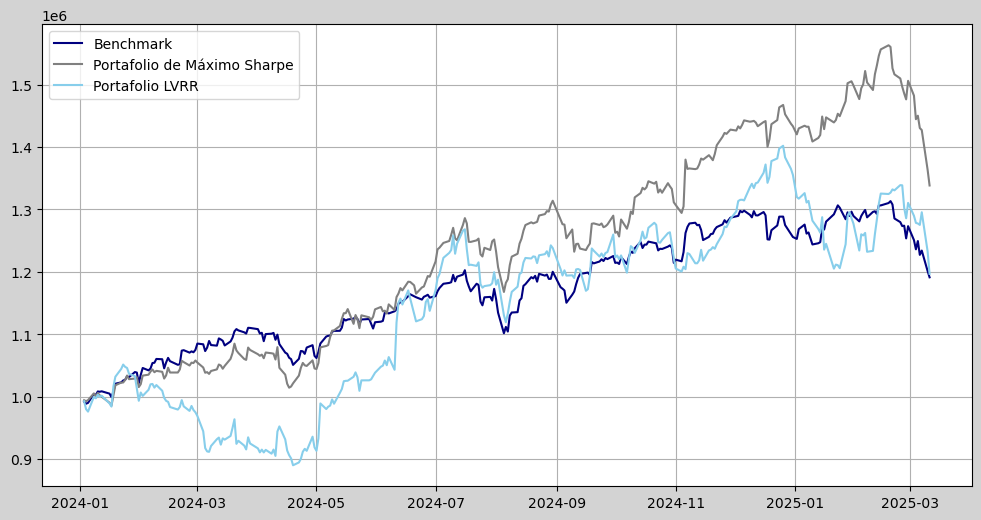

In [13]:
# Returns
sharpe_returns = portfolio_return(rt_test, w_sharpe)
lvrr_returns = portfolio_return(rt_test, w_lvrr)

cumulative_sharpe_returns = (1 + sharpe_returns).cumprod()
cumulative_lvrr_returns = (1 + lvrr_returns).cumprod()

cumulative_benchmark_returns = (1 + rt_benchmark_test).cumprod()

# DataFrames
cumulative_returns = pd.DataFrame({
    'Benchmark': cumulative_benchmark_returns.squeeze(),
    'Sharpe': pd.Series(cumulative_sharpe_returns, index=rt_test.index),
    'LVRR': pd.Series(cumulative_lvrr_returns, index=rt_test.index)
})

cumulative_returns_money = pd.DataFrame({
    'Benchmark': cumulative_benchmark_returns.squeeze() * 1000000,
    'Sharpe': pd.Series(cumulative_sharpe_returns, index=rt_test.index) * 1000000,
    'LVRR': pd.Series(cumulative_lvrr_returns, index=rt_test.index) * 1000000
})

pd.set_option('display.float_format', '{:.2%}'.format)
df_optimal = pd.DataFrame({
    'Ticker': tickers,
    'Sharpe': w_sharpe,
    'LVRR': w_lvrr
})
df_optimal.set_index('Ticker', inplace=True)

# Plots
plt.figure(figsize=(12, 6))

plt.plot(cumulative_returns_money['Benchmark'], label='Benchmark', c = 'navy')
plt.plot(cumulative_returns_money['Sharpe'], label='Portafolio de Máximo Sharpe', c = 'gray')
plt.plot(cumulative_returns_money['LVRR'], label='Portafolio LVRR', c = 'skyblue')

plt.legend()
plt.grid();

In [14]:
print(f'Pesos óptmio de las estrategias')
display(df_optimal.T)
print()

pd.reset_option('display.float_format')
print(f'Evolución de los rendimientos')
display(cumulative_returns)

print()

print(f'Evolución del valor del portafolio')
display(cumulative_returns_money)

for i in cumulative_returns_money.columns:
    print(f'El valor final del portafolio {i} es de {cumulative_returns_money[i].iloc[-1]:,.2f}')

Pesos óptmio de las estrategias


Ticker,AAPL,WMT,JPM,PG,META,V
Sharpe,42.61%,0.00%,51.07%,0.00%,6.32%,0.00%
LVRR,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%



Evolución de los rendimientos


,Benchmark,Sharpe,LVRR
Date,,,
2024-01-03,0.991833,0.994251,0.992512
2024-01-04,0.988639,0.992724,0.979907
2024-01-05,0.989993,0.994442,0.975975
2024-01-08,1.004126,1.005148,0.999569
2024-01-09,1.002602,0.999902,0.997307
...,...,...,...
2025-03-05,1.249421,1.450321,1.277502
2025-03-06,1.227243,1.430568,1.275280
2025-03-07,1.234121,1.427306,1.295547



Evolución del valor del portafolio


,Benchmark,Sharpe,LVRR
Date,,,
2024-01-03,9.918333e+05,9.942515e+05,9.925124e+05
2024-01-04,9.886385e+05,9.927236e+05,9.799074e+05
2024-01-05,9.899926e+05,9.944425e+05,9.759750e+05
2024-01-08,1.004126e+06,1.005148e+06,9.995690e+05
2024-01-09,1.002602e+06,9.999021e+05,9.973066e+05
...,...,...,...
2025-03-05,1.249421e+06,1.450321e+06,1.277502e+06
2025-03-06,1.227243e+06,1.430568e+06,1.275280e+06
2025-03-07,1.234121e+06,1.427306e+06,1.295547e+06


El valor final del portafolio Benchmark es de 1,191,263.99
El valor final del portafolio Sharpe es de 1,338,481.88
El valor final del portafolio LVRR es de 1,196,756.83


### Métricas de desempeño

In [15]:
returns_df = pd.DataFrame({
    'Sharpe': sharpe_returns,
    'LVRR': lvrr_returns,
})

X = rt_benchmark_test['SPY'].values.reshape(-1, 1)
y = [sharpe_returns, lvrr_returns]
betas = np.array([LinearRegression().fit(X, i).coef_[0] for i in y])

port_ret = returns_df.mean() * 252
port_vol = returns_df.std() * np.sqrt(252)
sharpe = (port_ret - rf) / port_vol
alpha = port_ret - (rf + betas * (((rt_benchmark_test.mean()).iloc[0] * 252)-rf))
sortino = (port_ret - rf) / (returns_df[returns_df < 0].std() * np.sqrt(252))

summary = pd.DataFrame({
    'Rendimiento Anual': port_ret,
    'Volatilidad Anual': port_vol,
    'Sharpe Ratio': sharpe,
    'Beta': betas,
    'Alpha': alpha,
    'Sortino Ratio': sortino
})
summary

,Rendimiento Anual,Volatilidad Anual,Sharpe Ratio,Beta,Alpha,Sortino Ratio
Sharpe,0.261812,0.169532,1.249391,0.925031,0.112700,1.695036
LVRR,0.180376,0.236991,0.550133,0.943594,0.029275,0.807250


In [16]:
total_return = [(cumulative_returns.iloc[-1] - 1).iloc[i] for i in range(len(cumulative_returns.columns))]
period_years = len(rt_test) / 252
anualized_returns = (np.ones(len(total_return)) + total_return) ** (1 / period_years) - 1

## Backtest Dinámico

In [17]:
train_dates = ['2021-01-01', '2023-12-31', '2024-03-31', '2024-06-30', '2024-09-30', '2024-12-31']
test_dates = ['2024-01-01', '2024-03-31', '2024-06-30', '2024-09-30', '2024-12-31', '2025-03-12']

price_train_dynamic = [price.loc[train_dates[0]:train_dates[i+1]] for i in range(len(train_dates)-1)]
rt_train_dynamic = [price_train_dynamic[i].pct_change().dropna() for i in range(len(price_train_dynamic))]

rt_test_total = price.loc[test_dates[0]:test_dates[-1]].pct_change().dropna()
rt_test_dynamic = [rt_test_total.loc[test_dates[i]:test_dates[i+1]] if i == 0
                   else rt_test_total.loc[pd.Timestamp(test_dates[i]) + pd.Timedelta(days=1):test_dates[i+1]]
                   for i in range(len(test_dates)-1)]

last_volume = [volume.loc[train_dates[0]:train_dates[i+1]] for i in range(len(train_dates)-1)]

### Máximo Ratio de Sharpe

In [18]:
rf_list = [0.05, 0.048, 0.047, 0.046, 0.045, 0.044]
sharpe_weights = [opt_sharpe(rt_train_dynamic[i], rf_list[i]) for i in range(len(rt_train_dynamic))]
sharpe_dynamic = [portfolio_return(rt_test_dynamic[i], sharpe_weights[i]) for i in range(len(rt_test_dynamic))]

sharpe_dynamic = np.concatenate(sharpe_dynamic)

cumulative_sharpe_dynamic_returns = (1 + sharpe_dynamic).cumprod()
cumulative_sharpe_dynamic_money = (1 + sharpe_dynamic).cumprod() * 1000000

Pesos para Q1


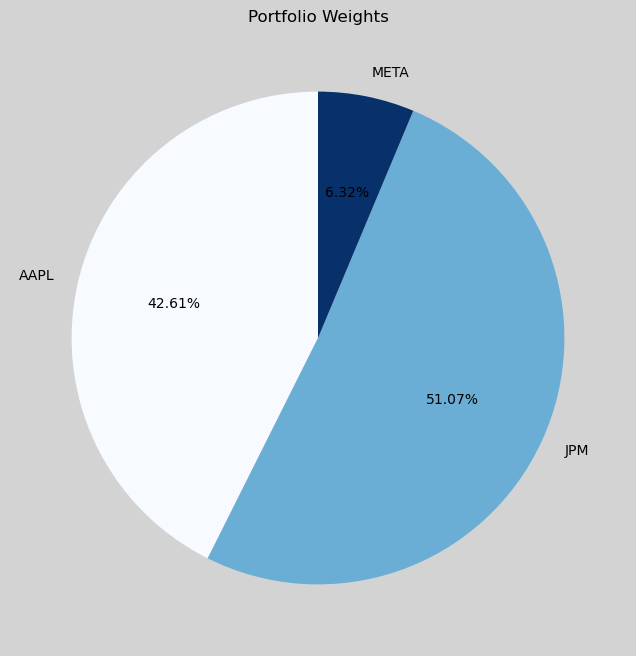

Pesos para Q2


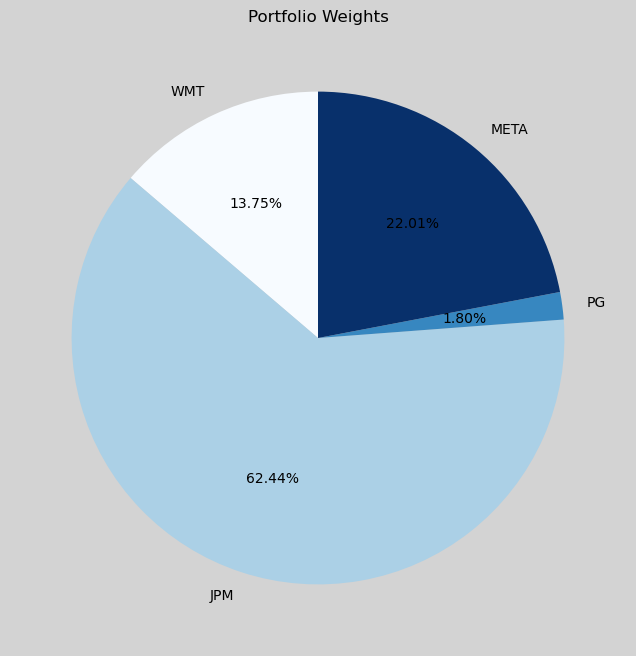

Pesos para Q3


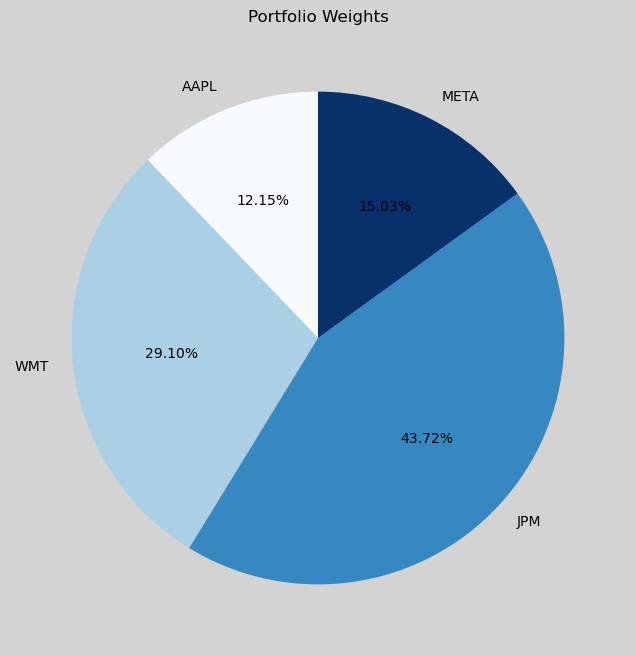

Pesos para Q4


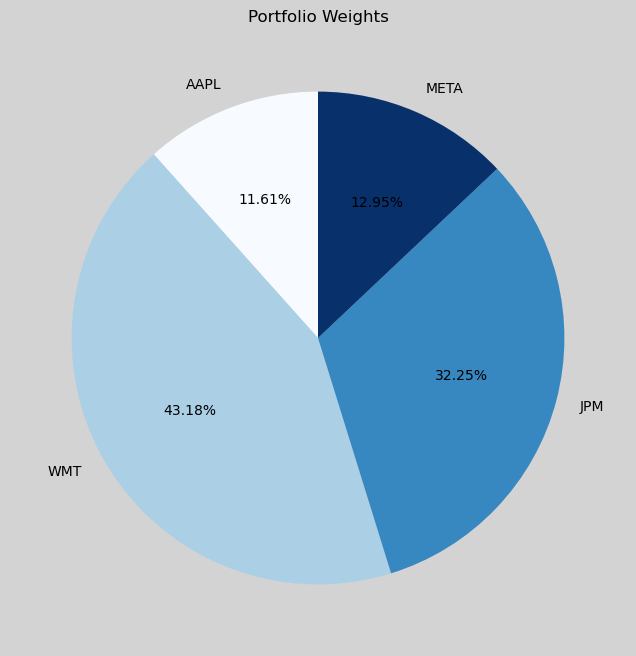

Pesos para Q5


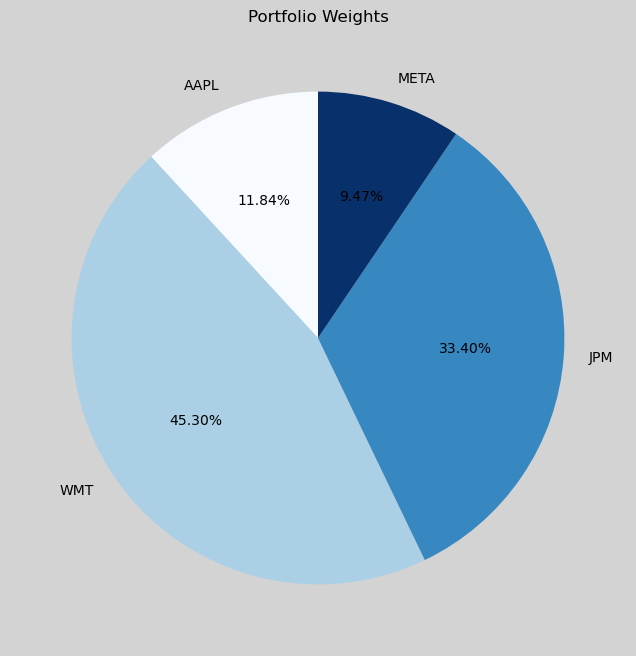

In [19]:
for i in range(len(sharpe_weights)):
    print(f'Pesos para Q{i+1}')
    vt.plot_weights(tickers, sharpe_weights[i])

### Liquidity Variance Return Ratio (LVRR)

In [20]:
lvrr_weights = []
lvrr_dynamic = []
pv_list = []
pv = 1000000.0

for i in range(len(rt_train_dynamic)):
    w_lvrr = lvrr(price_train_dynamic[i], last_volume[i], pv, rf_list[i])
    lvrr_weights.append(w_lvrr)

    returns = portfolio_return(rt_test_dynamic[i], w_lvrr)
    lvrr_dynamic.append(returns)

    cumulative_lvrr_ret = (1 + returns).cumprod()

    cumulative_lvrr_money = (1 + returns).cumprod() * pv

    pv = cumulative_lvrr_money[-1]
    pv_list.append(pv)

lvrr_dynamic = np.concatenate(lvrr_dynamic)

cumulative_lvrr_dynamic_returns = (1 + lvrr_dynamic).cumprod()
cumulative_lvrr_dynamic_money = (1 + lvrr_dynamic).cumprod() * 1000000

In [21]:
pv_list

[924902.0413992576,
 1026077.8200547819,
 1136420.5177657965,
 1222727.5568313156,
 1079482.859850217]

Pesos para Q1


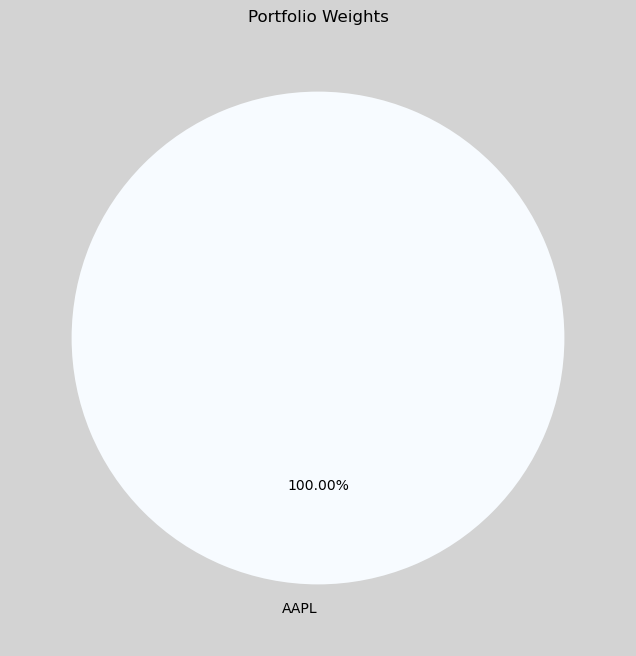

Pesos para Q2


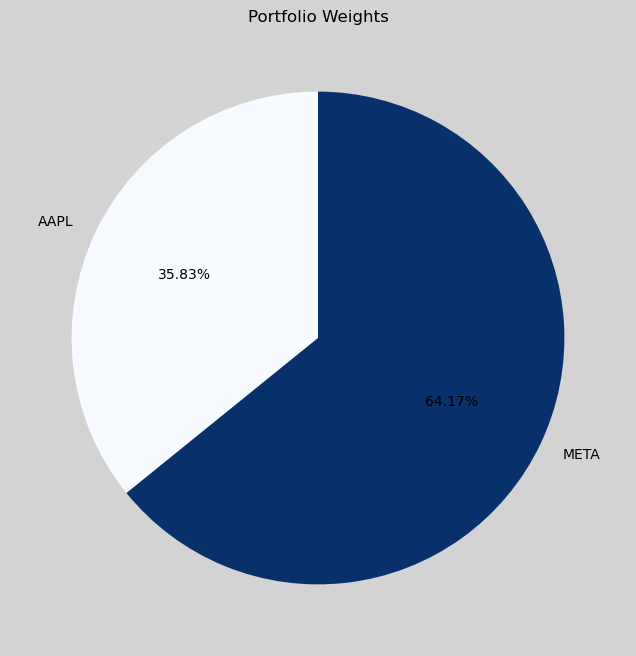

Pesos para Q3


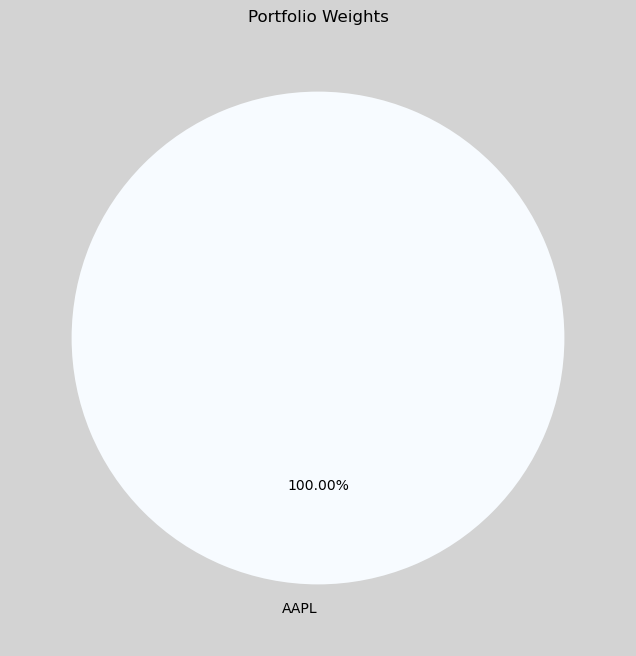

Pesos para Q4


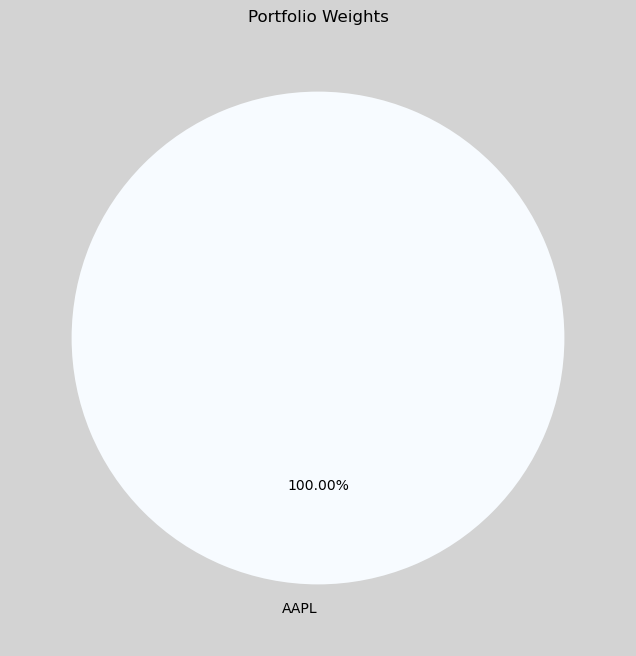

Pesos para Q5


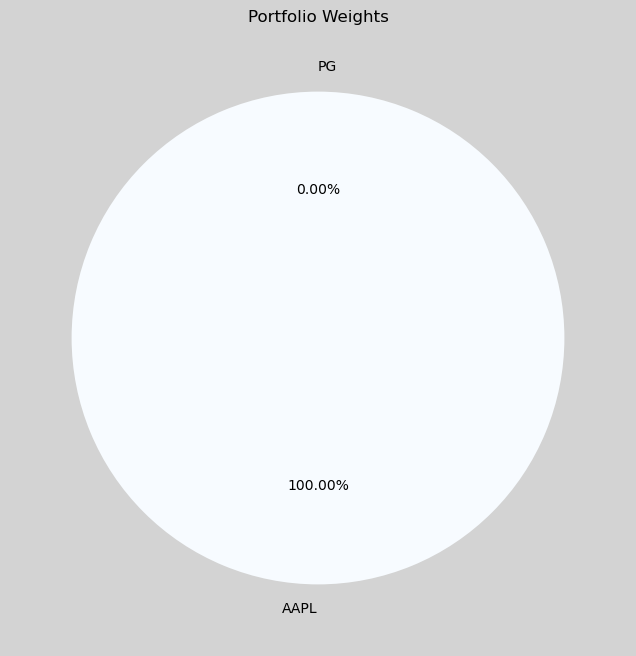

In [22]:
for i in range(len(lvrr_weights)):
    print(f'Pesos para Q{i+1}')
    vt.plot_weights(tickers, lvrr_weights[i])

### Gráfica

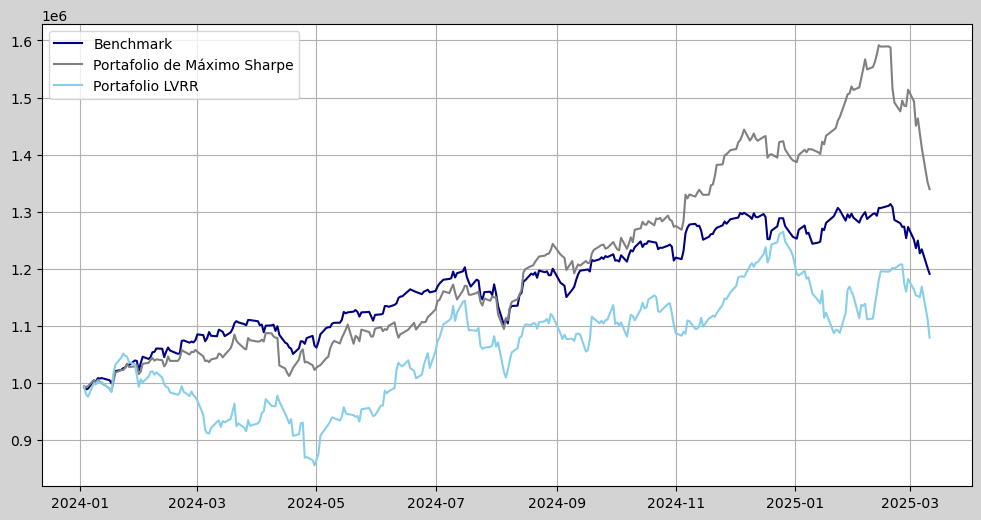

In [23]:
cumulative_returns_dynamic = pd.DataFrame({
    'Benchmark': cumulative_benchmark_returns.squeeze(),
    'Sharpe': pd.Series(cumulative_sharpe_dynamic_returns, index=rt_test_total.index),
    'LVRR': pd.Series(cumulative_lvrr_dynamic_returns, index=rt_test_total.index)
})

cumulative_money_dynamic = pd.DataFrame({
    'Benchmark': cumulative_benchmark_returns.squeeze() * 1000000,
    'Sharpe': pd.Series(cumulative_sharpe_dynamic_money, index=rt_test_total.index),
    'LVRR': pd.Series(cumulative_lvrr_dynamic_money, index=rt_test_total.index)
})

pd.set_option('display.float_format', '{:.2%}'.format)
df_sharpe = pd.DataFrame(sharpe_weights, columns = rt.keys())
df_sharpe.index = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

df_lvrr = pd.DataFrame(lvrr_weights, columns = rt.keys())
df_lvrr.index = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

plt.figure(figsize=(12, 6))

plt.plot(cumulative_money_dynamic['Benchmark'], label='Benchmark', c = 'navy')
plt.plot(cumulative_money_dynamic['Sharpe'], label='Portafolio de Máximo Sharpe', c = 'gray')
plt.plot(cumulative_money_dynamic['LVRR'], label='Portafolio LVRR', c = 'skyblue')

plt.legend()
plt.grid();

In [24]:
print(f'Pesos óptmio de las estrategias')
print('Sharpe')
display(df_sharpe)
print('LVRR')
display(df_lvrr)
print()

pd.reset_option('display.float_format')
print(f'Evolución de los rendimientos')
display(cumulative_returns_dynamic)

print()

print(f'Evolución del valor del portafolio')
display(cumulative_money_dynamic)

for i in cumulative_money_dynamic.columns:
    print(f'El valor final del portafolio de {i} es de {cumulative_money_dynamic[i].iloc[-1]:,.2f}')

Pesos óptmio de las estrategias
Sharpe


Ticker,AAPL,WMT,JPM,PG,META,V
Q1,42.61%,0.00%,51.07%,0.00%,6.32%,0.00%
Q2,0.00%,13.75%,62.44%,1.80%,22.01%,0.00%
Q3,12.15%,29.10%,43.72%,0.00%,15.03%,0.00%
Q4,11.61%,43.18%,32.25%,0.00%,12.95%,0.00%
Q5,11.84%,45.30%,33.40%,0.00%,9.47%,0.00%


LVRR


Ticker,AAPL,WMT,JPM,PG,META,V
Q1,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Q2,35.93%,0.00%,0.00%,0.00%,64.35%,0.00%
Q3,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Q4,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Q5,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%



Evolución de los rendimientos


,Benchmark,Sharpe,LVRR
Date,,,
2024-01-03,0.991833,0.994251,0.992512
2024-01-04,0.988639,0.992724,0.979907
2024-01-05,0.989993,0.994442,0.975975
2024-01-08,1.004126,1.005148,0.999569
2024-01-09,1.002602,0.999902,0.997307
...,...,...,...
2025-03-05,1.249421,1.463454,1.152315
2025-03-06,1.227243,1.438178,1.150311
2025-03-07,1.234121,1.411994,1.168593



Evolución del valor del portafolio


,Benchmark,Sharpe,LVRR
Date,,,
2024-01-03,9.918333e+05,9.942515e+05,9.925124e+05
2024-01-04,9.886385e+05,9.927236e+05,9.799074e+05
2024-01-05,9.899926e+05,9.944425e+05,9.759750e+05
2024-01-08,1.004126e+06,1.005148e+06,9.995690e+05
2024-01-09,1.002602e+06,9.999021e+05,9.973066e+05
...,...,...,...
2025-03-05,1.249421e+06,1.463454e+06,1.152315e+06
2025-03-06,1.227243e+06,1.438178e+06,1.150311e+06
2025-03-07,1.234121e+06,1.411994e+06,1.168593e+06


El valor final del portafolio de Benchmark es de 1,191,263.99
El valor final del portafolio de Sharpe es de 1,339,550.58
El valor final del portafolio de LVRR es de 1,079,482.86


### Métricas

In [25]:
returns_df = pd.DataFrame({
    'Sharpe': sharpe_dynamic,
    'LVRR': lvrr_dynamic,
})

X = rt_benchmark_test['SPY'].values.reshape(-1, 1)
y = [sharpe_returns, lvrr_returns]
betas = np.array([LinearRegression().fit(X, i).coef_[0] for i in y])

port_ret = returns_df.mean() * 252
port_vol = returns_df.std() * np.sqrt(252)
sharpe = (port_ret - rf) / port_vol
alpha = port_ret - (rf + betas * (((rt_benchmark_test.mean()).iloc[0] * 252)-rf))
sortino = (port_ret - rf) / (returns_df[returns_df < 0].std() * np.sqrt(252))

summary = pd.DataFrame({
    'Rendimiento Anual': port_ret,
    'Volatilidad Anual': port_vol,
    'Sharpe Ratio': sharpe,
    'Beta': betas,
    'Alpha': alpha,
    'Sortino Ratio': sortino
})
summary

,Rendimiento Anual,Volatilidad Anual,Sharpe Ratio,Beta,Alpha,Sortino Ratio
Sharpe,0.260957,0.159719,1.320802,0.925031,0.111845,1.541005
LVRR,0.091484,0.230190,0.180217,0.943594,-0.059617,0.229781
